# Convolutional Layers:

Extract spatial features like edges and patterns.
Use multiple layers with increasing filters (e.g., 32, 64, 128).
Pooling Layers:

Reduce spatial dimensions to make computation more efficient.
Typically, use MaxPooling (e.g., 2x2).
Fully Connected (Dense) Layers:

Map extracted features to character classes.
Activation Functions:

Use ReLU for intermediate layers and softmax for the output layer.



- Compile multiple datasets for more generalization
- Make all dataset grouped and uniformed
- Simple EDA of data
- Make Split Ratio of 65/15/10 Train, Valid, Test (ADD LIMIT FOR LESSER TIME TRAINING)
- Data Augmentation for training data
- Preprocessing of all data
- Optuna Framework for best hyper parameters
- Apply optimal hyperparameters
- Model Evaluation

# Exploratory Data Analysis

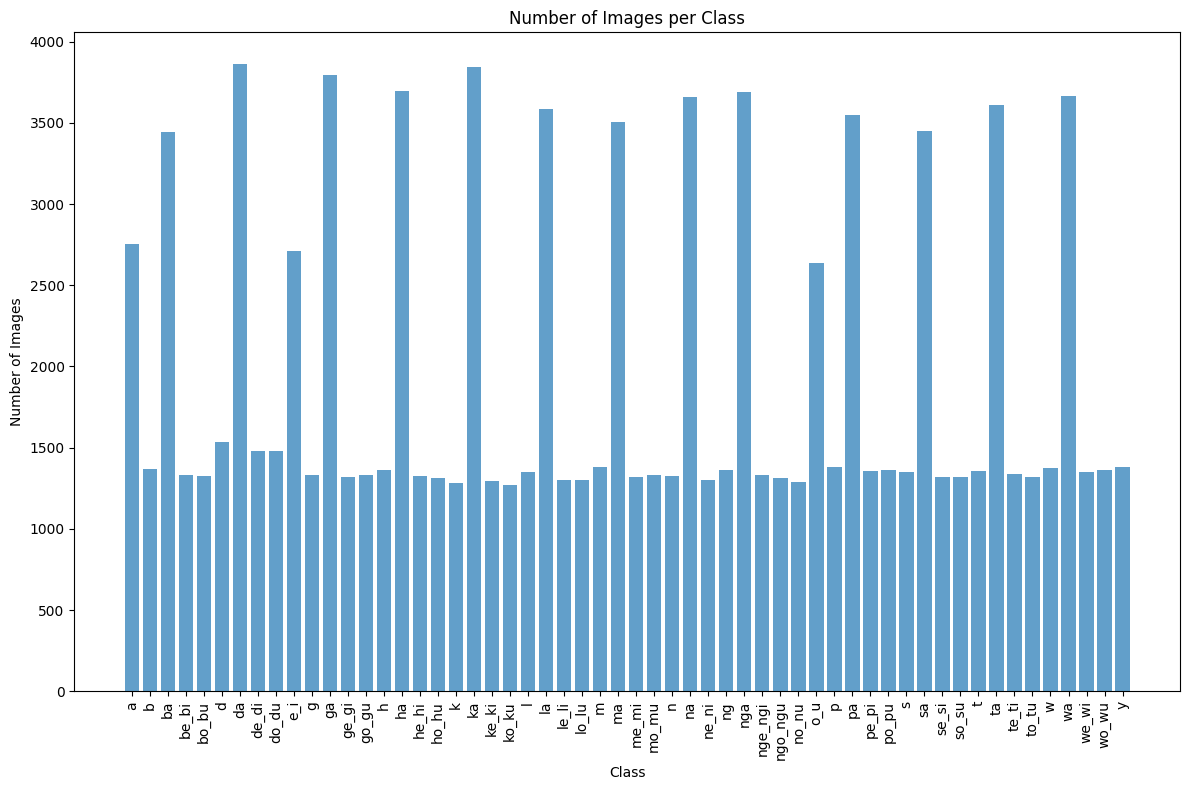

In [3]:
import matplotlib.pyplot as plt

# Visualization: Number of classes
plt.figure(figsize=(12, 8))
plt.bar(class_counts.keys(), class_counts.values(), alpha=0.7)
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [4]:
import os

# Define the dataset path
dataset_path = "D:/WORK/Baybayin App Project/dataset"

# Count all images in the folder and its subfolders
total_images = 0
for root, dirs, files in os.walk(dataset_path):
  total_images += len([f for f in files if f.endswith(('.jpg', '.png'))])

print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 110486


In [6]:
# Checking the directory structure and extracting unique image file types

# Collect all unique image extensions
unique_extensions = set()

# Iterate over the folders in the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        unique_extensions.add(ext)

# Display the unique image file types
unique_extensions


{'.jpg'}

Since the dataset are collected from multiple data sources, a duplicate may happen.

In [13]:
import hashlib

def calculate_hash(image_path):
    """Calculate the MD5 hash of an image file."""
    hash_md5 = hashlib.md5()
    with open(image_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_duplicate_images(dataset_directory):
    """Find and count duplicate images per class."""
    duplicates_count = {}
    
    for class_folder in os.listdir(dataset_directory):
        class_path = os.path.join(dataset_directory, class_folder)
        if os.path.isdir(class_path):
            hash_set = set()
            duplicates = 0
            
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    img_hash = calculate_hash(image_path)
                    if img_hash in hash_set:
                        duplicates += 1
                    else:
                        hash_set.add(img_hash)
                except Exception as e:
                    pass  # Skip files that cannot be read
            
            duplicates_count[class_folder] = duplicates
    
    return duplicates_count

# Use the function to find duplicates in the dataset
dataset_directory = r"D:\WORK\Baybayin App Project\dataset"
duplicates_count = find_duplicate_images(dataset_directory)

# Display the results
duplicates_df = pd.DataFrame({
    "Class": duplicates_count.keys(),
    "Duplicate Count": duplicates_count.values()
}).sort_values(by="Duplicate Count", ascending=False)

# Display the duplicate counts
print(duplicates_df)


      Class  Duplicate Count
17    ho_hu              972
29    mo_mu              945
50    to_tu              943
58    yo_yu              940
42    po_pu              921
21    ko_ku              868
54    wo_wu              849
46    so_su              841
13    go_gu              841
36  ngo_ngu              825
8     do_du              807
37    no_nu              805
4     bo_bu              771
32    ne_ni              527
34      nga              302
40       pa              268
0         a              268
48       ta              267
15       ha              201
25    lo_lu              200
6        da              197
38      o_u              183
14        h              171
2        ba              164
52       wa              156
56       ya              127
19       ka              100
44       sa               92
9       e_i               55
3     be_bi               49
7     de_di               43
20    ke_ki               38
16    he_hi               37
45    se_si   

# Preprocessing the grouped dataset (General Preprocess)

In [14]:
def delete_duplicate_images(dataset_directory):
    """Find and delete duplicate images per class."""
    for class_folder in os.listdir(dataset_directory):
        class_path = os.path.join(dataset_directory, class_folder)
        if os.path.isdir(class_path):
            hash_set = set()
            
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    img_hash = calculate_hash(image_path)
                    if img_hash in hash_set:
                        os.remove(image_path)  # Delete the duplicate image
                    else:
                        hash_set.add(img_hash)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Call the function to delete duplicate images
delete_duplicate_images(dataset_directory)

print("Duplicate images have been deleted.")


Duplicate images have been deleted.


In [16]:
import os

# Define the dataset path
dataset_path = "D:/WORK/Baybayin App Project/dataset"

# Count all images in the folder and its subfolders
total_images = 0
for root, dirs, files in os.walk(dataset_path):
  total_images += len([f for f in files if f.endswith(('.jpg', '.png'))])

print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 95207


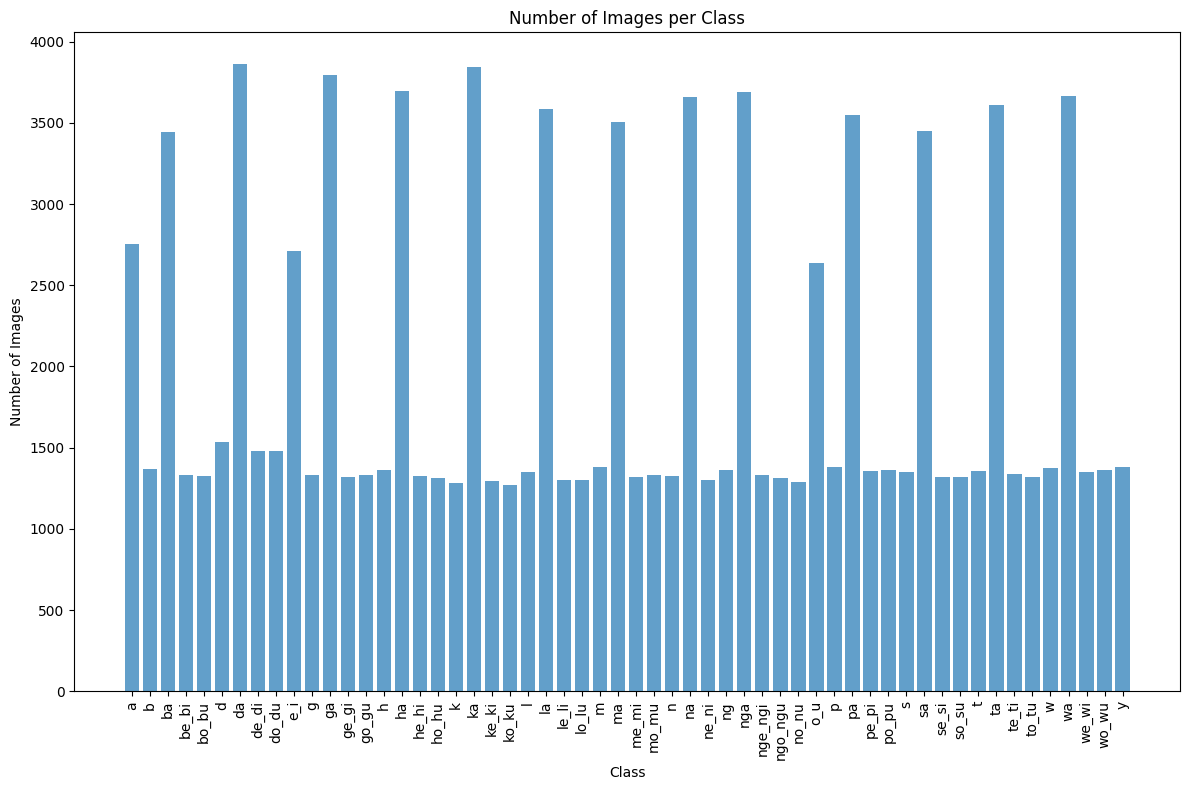

In [15]:
import matplotlib.pyplot as plt

# Visualization: Number of classes
plt.figure(figsize=(12, 8))
plt.bar(class_counts.keys(), class_counts.values(), alpha=0.7)
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


# Splitting of Dataset

Since the dataset is around 110k+ number of images cut down to 95k+ and has 59 classes, a splitting of dataset is done and a limit for each class was introduced to take into account the training time it will take.

Some classes have low number of images, so a manual check is done and found that the count of images in some classes are not correct.

In [17]:
import shutil
import random

def balance_dataset(dataset_directory, output_directory, limit=1000):
    """
    Balance the dataset by limiting the number of images per class to a specified limit.
    Images are picked randomly to maintain generalization.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for class_folder in os.listdir(dataset_directory):
        class_path = os.path.join(dataset_directory, class_folder)
        output_class_path = os.path.join(output_directory, class_folder)

        if os.path.isdir(class_path):
            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)
            
            # List all images in the class folder
            images = os.listdir(class_path)
            
            # Randomly sample up to the limit
            selected_images = random.sample(images, min(len(images), limit))
            
            # Copy the selected images to the new directory
            for image_file in selected_images:
                source_path = os.path.join(class_path, image_file)
                dest_path = os.path.join(output_class_path, image_file)
                try:
                    shutil.copy(source_path, dest_path)
                except Exception as e:
                    print(f"Error copying {source_path} to {dest_path}: {e}")

# Paths to the original dataset and the output balanced dataset
dataset_directory = r"D:\WORK\Baybayin App Project\dataset"
output_directory = r"D:\WORK\Baybayin App Project\balanced_dataset"

# Balance the dataset with a limit of 1000 images per class
balance_dataset(dataset_directory, output_directory, limit=1000)

print("Balanced dataset has been created.")


Balanced dataset has been created.


In [1]:
import os

# Define the dataset path
dataset_path = "D:/WORK/Baybayin App Project/balanced_dataset"

# Count all images in the folder and its subfolders
total_images = 0
for root, dirs, files in os.walk(dataset_path):
  total_images += len([f for f in files if f.endswith(('.jpg', '.png'))])

print(f"Total number of images in the dataset: {total_images}")

import matplotlib.pyplot as plt

# Visualization: Number of classes
plt.figure(figsize=(12, 8))
plt.bar(class_counts.keys(), class_counts.values(), alpha=0.7)
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


Total number of images in the dataset: 48133


NameError: name 'class_counts' is not defined

<Figure size 1200x800 with 0 Axes>

In [18]:
def split_dataset(balanced_dataset_directory, output_directory, train_ratio=0.65, val_ratio=0.15, test_ratio=0.10):
    """
    Split the balanced dataset into train, validation, and test sets based on the given ratios.
    """
    # Check if output directories exist, create them if not
    train_dir = os.path.join(output_directory, "train")
    val_dir = os.path.join(output_directory, "val")
    test_dir = os.path.join(output_directory, "test")

    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    for class_folder in os.listdir(balanced_dataset_directory):
        class_path = os.path.join(balanced_dataset_directory, class_folder)

        if os.path.isdir(class_path):
            # Create class subdirectories in train, val, and test folders
            for split_dir in [train_dir, val_dir, test_dir]:
                split_class_path = os.path.join(split_dir, class_folder)
                if not os.path.exists(split_class_path):
                    os.makedirs(split_class_path)
            
            # List all images in the class folder
            images = os.listdir(class_path)
            random.shuffle(images)

            # Calculate split indices
            total_images = len(images)
            train_count = int(total_images * train_ratio)
            val_count = int(total_images * val_ratio)
            
            train_images = images[:train_count]
            val_images = images[train_count:train_count + val_count]
            test_images = images[train_count + val_count:]

            # Move images to respective directories
            for image_file in train_images:
                shutil.copy(os.path.join(class_path, image_file), os.path.join(train_dir, class_folder, image_file))
            
            for image_file in val_images:
                shutil.copy(os.path.join(class_path, image_file), os.path.join(val_dir, class_folder, image_file))
            
            for image_file in test_images:
                shutil.copy(os.path.join(class_path, image_file), os.path.join(test_dir, class_folder, image_file))

# Paths to the balanced dataset and output directories
balanced_dataset_directory = r"D:\WORK\Baybayin App Project\balanced_dataset"
output_split_directory = r"D:\WORK\Baybayin App Project\split_dataset"

# Split the dataset
split_dataset(balanced_dataset_directory, output_split_directory, train_ratio=0.65, val_ratio=0.15, test_ratio=0.10)

print("Dataset has been split into train, validation, and test sets.")


Dataset has been split into train, validation, and test sets.


# Split Dataset Loading

In [4]:
from collections import defaultdict

# Initialize a dictionary to store the count of images per split
split_counts = defaultdict(int)

# Iterate through each split directory
for split in splits:
  split_path = os.path.join(new_dataset_path, split)
  # Iterate through each class subdirectory
  for class_name in os.listdir(split_path):
    class_split_path = os.path.join(split_path, class_name)
    if os.path.isdir(class_split_path):
      # Count the number of images in the class subdirectory
      split_counts[split] += len([img for img in os.listdir(class_split_path) if img.endswith(('.jpg', '.png'))])

# Print the counts
for split, count in split_counts.items():
  print(f"{split}: {count} images")


train: 22152 images
val: 14947 images
test: 62734 images


# Data Augmentation and Pre-processing